In [6]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

training_dir = '/content/data/training'
evaluate_dir = '/content/data/processed_eval'

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/data/data.zip', 'r')
zip_ref.extractall(evaluate_dir)
zip_ref.close()

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/data/Utah_dup.zip', 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#https://www.kaggle.com/code/hamzamanssor/surface-crack-detection-using-dl-models/notebook#Functions

import cv2
from tqdm.notebook import tqdm

In [8]:
path = '/content/data/training/Utah/'
path_all = list(glob.glob(path + '**/*.png', recursive=True))

path_neg = list(glob.glob(path + 'U/*.png', recursive=True))
path_pos = list(glob.glob(path + 'C/*.png', recursive=True))

print("Number of positive data: {}".format(len(path_pos)))
print("Number of negative data: {}".format(len(path_neg)))

Number of positive data: 16968
Number of negative data: 47608


In [9]:
label_translate = lambda c : "POSITIVE" if c == "C" else "NEGATIVE"
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Label
0,/content/data/training/Utah/C/7113-223.png,C
1,/content/data/training/Utah/C/7087-47.png,C
2,/content/data/training/Utah/U/7116-240.png,U
3,/content/data/training/Utah/U/7118-17.png,U
4,/content/data/training/Utah/C/a7077-50.png,C


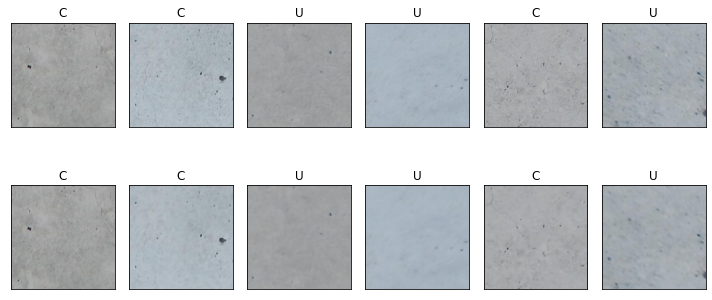

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    index = i % (len(axes.flat) // 2)
    image = plt.imread(data.File_Path[index], 0)
    if i > len(axes.flat) // 2:
        image = cv2.bilateralFilter(image, 7, 45, 125)
    ax.imshow(image)
    ax.set_title(data.Label[index])
plt.tight_layout()
# top row   : original
# bottom row: filtered
plt.show()

In [11]:
import random
SEED = random.randint(1, 100)
# Train and test split
train_df, test_df = train_test_split(data, test_size=0.2, stratify = data["Label"]) 

In [12]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.2)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(224,224),
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=42
    )

    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(224,224),
        class_mode='categorical',
        batch_size=64,
        shuffle=42
    )
    
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(224,224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )

    return train_gen, valid_gen, test_gen

In [59]:
def func1(name_model):
    pre_model = name_model(
                    input_shape=(224, 224, 3),
                    include_top=True,
                    classes=2,
                    classifier_activation="softmax",
                    weights=None
                )

    pre_model.trainable = True
    inputs = pre_model.input
    outputs = pre_model.output
    # x = Dense(64, activation='relu')(pre_model.output)
    # x = Dense(64, activation='relu')(x)
    # outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]

    return model, my_callbacks

def func(name_model):
    pre_model = name_model(input_shape=(224,224, 3),
                   include_top=True,
                   weights='imagenet',
                   #weights=None,
                   pooling='avg')
    pre_model.trainable = False
    #pre_model.trainable = True
    inputs = pre_model.input

    x = Dense(64, activation='relu')(pre_model.get_layer("predictions").output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
    return model, my_callbacks

In [60]:
def plot(history,df_test,test_gen,train_gen):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    pred = model.predict(test_gen)
    pred = np.argmax(pred,axis=1)
    labels = train_gen.class_indices
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    # cm = confusion_matrix(df_test.Label, pred)
    ConfusionMatrixDisplay.from_predictions(df_test.Label, pred, normalize='all')
    plt.show()

    clr = classification_report(df_test.Label, pred, target_names=["Positive", "Negative"])
    print(clr)

    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1], 0))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [61]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

#VGG16

In [62]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess(data):
    #data = cv2.bilateralFilter(data, 5, 45, 125)
    return preprocess_input(data)

vgg_pre = preprocess
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre, train_df, test_df)

Found 51660 validated image filenames belonging to 2 classes.
Found 51660 validated image filenames belonging to 2 classes.
Found 40000 validated image filenames belonging to 2 classes.


In [63]:
model, callback=func(VGG16)
# model = VGG16(
#             input_shape=(224, 224, 3),
#             include_top=True,
#             classes=2,
#             classifier_activation="softmax",
#             weights=None
#         )
# model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [64]:
history = model.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    callbacks=callback
)

Epoch 1/100
808/808 [==============================] - 307s 379ms/step - loss: 0.4270 - accuracy: 0.8184 - val_loss: 0.3858 - val_accuracy: 0.8395
Epoch 2/100
808/808 [==============================] - 302s 374ms/step - loss: 0.3895 - accuracy: 0.8389 - val_loss: 0.3797 - val_accuracy: 0.8438
Epoch 3/100
808/808 [==============================] - 302s 373ms/step - loss: 0.3735 - accuracy: 0.8451 - val_loss: 0.3605 - val_accuracy: 0.8525
Epoch 4/100
808/808 [==============================] - 301s 372ms/step - loss: 0.3703 - accuracy: 0.8478 - val_loss: 0.3578 - val_accuracy: 0.8486
Epoch 5/100
808/808 [==============================] - 300s 372ms/step - loss: 0.3589 - accuracy: 0.8527 - val_loss: 0.3501 - val_accuracy: 0.8564
Epoch 6/100
808/808 [==============================] - 300s 372ms/step - loss: 0.3529 - accuracy: 0.8553 - val_loss: 0.3380 - val_accuracy: 0.8614
Epoch 7/100
808/808 [==============================] - 301s 372ms/step - loss: 0.3476 - accuracy: 0.8567 - val_loss: 0

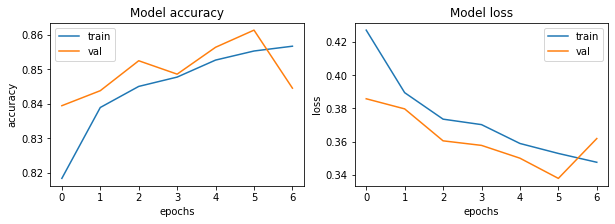

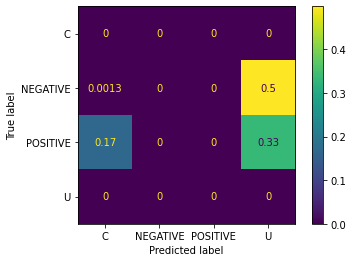

ValueError: ignored

In [65]:
history=plot(history,test_df,test_gen_VGG,train_gen_VGG)

In [ ]:
# load existing model
# from keras import models
# model = models.load_model("/content/drive/MyDrive/Colab Notebooks/model_pretrained")

In [66]:
result = result_test(test_gen_VGG,model)

KeyboardInterrupt: ignored

In [67]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name = 'File_Path').astype(str)
    labels = pd.Series(label, name = 'Label', index = filepaths.index)
    df = pd.concat([filepaths, labels], axis = 1)
    return df

from pathlib import Path

base_dir = "/content/data/processed_eval/data/blur"
positive_dir = Path(base_dir + "/Positive")
negative_dir = Path(base_dir + "/Negative")

# create positive and negative df
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")
test_df = positive_df.append(negative_df, ignore_index=True)

test_datagen = ImageDataGenerator(preprocessing_function=vgg_pre)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='File_Path',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=1,
)

Found 40000 validated image filenames belonging to 2 classes.


array([[0.45417643, 0.5458235 ]], dtype=float32)

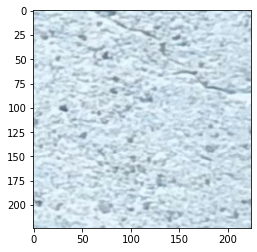

In [68]:
img = cv2.imread("/content/data/training/Utah/C/001-125.png")
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img = np.expand_dims(vgg_pre(img), axis=0)
model.predict(img)

In [69]:
from time import process_time_ns
# start = process_time_ns()
# test_pred_label = model.predict(test_gen, steps=len(test_df))
# end = process_time_ns()
# 
# diff_in_ns = end - start
# total_count = len(test_df)
# print(f"Time used to do {total_count} predictions: {diff_in_ns / (10**9)}s")
# print(f"Time used to do 1 prediction: {diff_in_ns / (10**9) / total_count}s")

import tensorflow as tf
from keras.preprocessing.image import img_to_array

# Create boolean function
def label_generator(index):
    if index == 0:
        return "POSITIVE"
    else:
        return "NEGATIVE"

# Create getter function 
# Inputs are your image directories and the CNN model
def single_prediction_generator(image_dir,model):
    img_path = image_dir
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_array = img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)

    # Return the confidence interval for image
    prediction = model.predict(img_preprocessed)
    index = np.argmax(prediction[0])
    label = label_generator(index)
    
    # Return index
    return label

# return an array of the predicted labels
def prediction_array_generator(category_df,model):
    predicted_label = []
    
    total_time_ns = 0
    # Iterate through the dataframe
    for image_dir in tqdm(category_df['File_Path']):
        start = process_time_ns()
        temp = single_prediction_generator(image_dir,model)
        end = process_time_ns()
        
        total_time_ns += end - start

        predicted_label.append(temp)        
    
    print(f"Total time exectued: {total_time_ns / 1000000}ms")
    print(f"Average time exectued per prediction: {(total_time_ns / 1000000) / 40000}ms")
    # Return the list of the prediction label
    return predicted_label


In [70]:
labels = test_gen.class_indices
labels = dict((v,k) for k,v in labels.items())

pred = prediction_array_generator(test_df, model)

  0%|          | 0/40000 [00:00<?, ?it/s]

Total time exectued: 2016834.207922ms


In [71]:
test_df.insert(2,"VGG-16", pred)

In [72]:
test_df

,File_Path,Label,VGG-16
0,/content/data/processed_eval/data/blur/Positiv...,POSITIVE,NEGATIVE
1,/content/data/processed_eval/data/blur/Positiv...,POSITIVE,POSITIVE
2,/content/data/processed_eval/data/blur/Positiv...,POSITIVE,NEGATIVE
3,/content/data/processed_eval/data/blur/Positiv...,POSITIVE,NEGATIVE
4,/content/data/processed_eval/data/blur/Positiv...,POSITIVE,POSITIVE
...,...,...,...
39995,/content/data/processed_eval/data/blur/Negativ...,NEGATIVE,NEGATIVE
39996,/content/data/processed_eval/data/blur/Negativ...,NEGATIVE,NEGATIVE
39997,/content/data/processed_eval/data/blur/Negativ...,NEGATIVE,NEGATIVE
39998,/content/data/processed_eval/data/blur/Negativ...,NEGATIVE,NEGATIVE


In [73]:
# Define true_positive
# return a list
# must positive quanity to be taken in
def true_positive(category_df):
    tp_models = []
    count_VGG16 = 0
    count_Resnet50 = 0
    for i in range(len(category_df)):
        if category_df["Label"][i] == category_df["Resnet-50"][i]:
            count_Resnet50 += 1
            
    tp_VGG = count_VGG16 
    tp_Resnet = count_Resnet50
    tp_models.append(tp_VGG)
    tp_models.append(tp_Resnet)
    return tp_models

# Define false negative
def false_negative(tp_models,category_df):
    fn_models = []
    fn_vgg = len(category_df) - tp_models[0]
    fn_resnet50 = len(category_df) - tp_models[1]
    fn_models.append(fn_vgg)
    fn_models.append(resnet50)
    return fp_models

def true_negative(category_df):
    tn_models = []
    count_VGG16 = 0
    count_Resnet50 = 0
    for i in range(len(category_df)):
        if category_df["Label"][i] == category_df["Resnet-50"][i]:
            count_Resnet50 += 1
    tn_VGG = count_VGG16
    tn_Resnet50 = count_Resnet50
    tn_models.append(tn_VGG)
    tn_models.append(tn_Resnet50)
    return tn_models

def false_positive(tn_models,category_df):
    fp_models = []
    fp_vgg = 1 - tn_models[0]
    fp_resnet = 1 - tn_models[1]
    fp_models.append(fp_vgg)
    fp_models.append(fp_resnet)
    return fp_models

def test(category_df):
    tp = fp = tn = fn = 0
    for i in range(len(category_df)):
        if category_df["Label"][i] == category_df["VGG-16"][i]:
            if category_df["VGG-16"][i] == "NEGATIVE": tn += 1
            else: tp += 1
        else:
            if category_df["VGG-16"][i] == "NEGATIVE": fn += 1
            else: fp += 1

    return tp, fp, tn, fn

In [74]:
tp, fp, tn, fn = test(test_df)
print(f"True Positive: {tp}")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")

True Positive: 6667
True Negative: 19950
False Positive: 50
False Negative: 13333


In [75]:
tn /= len(test_df)
tp /= len(test_df)
fn /= len(test_df)
fp /= len(test_df)

# calculate the accuracy based on the number of true positives and true negatives
accuracy = (tp + tn) / (tp + tn + fp + fn)
# calculate the precision based on the number of true positives and false positives
precision = tp / (tp + fp)
# calculate the recall based on the number of true positives and the number of positives
recall = tp / (tp + fn)
# calculate the f1 score based on the precision and the recall
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {round(accuracy, 5)}")
print(f"Precision: {round(precision, 5)}")
print(f"Recall: {round(recall, 5)}")
print(f"F1 Score: {round(f1_score, 5)}")

Accuracy: 0.66543
Precision: 0.99256
Recall: 0.33335
F1 Score: 0.49908


In [76]:
for i in range(len(pred)):
    pred[i] = labels[np.argmax(pred[i], axis=1)]

print(pred)

AxisError: ignored

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_df["Label"], pred)
plt.show()
# print(test_df["Label"])
# print(pd.DataFrame(pred))
# RocCurveDisplay.from_predictions(test_df["Label"], pd.DataFrame(pred), pos_label='C')
# plt.show()
cl_rpt = classification_report(test_df["Label"], pred, target_names=["NEGATIVE", "POSITIVE"])
print(cl_rpt)